In [1]:
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType

Welcome to JupyROOT 6.12/06


In [2]:
class WiggleFit:

    '''
       Class of function which creates a wiggle fit function to be passed into a TF1.
       Takes the following inputs:
           blindingPhrase (str): Blinding phrase used in the BlindersPy3 class
           kind (str): uses the dict implemented in this class to determine which form to use    
    '''
        
    def getFunc(self):
        return self.funcDict[self.kind]
        
    def five_parameter(self, x,p):
        norm  = p[0]
        life  = p[1]
        asym  = p[2]
        R     = p[3]
        phi   = p[4]

        time  = x[0]
        omega = self.getBlinded.paramToFreq(R)

        return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))
    
    
    def __init__(self, blindingPhrase, kind):
        self.getBlinded = Blinders(FitType.Omega_a, str(blindingPhrase))
        self.funcDict = { "5par" : self.five_parameter }
        
        if kind in self.funcDict.keys():
            self.kind = kind
        else:
            raise ValueError("ERROR: Function corresponding to "+str(kind)+" not found.")
    
    def __call__(self, x, p):
        return (self.getFunc())(x, p)

In [58]:
class BuildTF1:
    '''
        Class which takes as input a WiggleFit object and uses it to construct a TF1 with the correct parameters / parameter names
        Takes the following inputs:
            func (WiggleFit): the function to fit
            nPar (int): number of parameters
            kind (str): the kind of function (somewhat redundant, but one could imagine having multiple functions with the same nPar)
            name (str): the to give the function
            fitLow (double): the lower bound of the function
            fitHigh (double): the upper bound of the function
    '''
    
    def __init__(self, func, nPar, kind, name, fitLow, fitHigh):
        if(func.kind != kind):
            raise ValueError("The kind of function being defined here does not match")
        self.f = r.TF1(name, func, fitLow, fitHigh, nPar)
        self.nPar = nPar
        self.name = name
        self.fitLow = fitLow
        self.fitHigh = fitHigh
        self.funcRaw = func
        self.kind = kind
        self.nameDict = { "5par" : ["N", "#tau_{#mu}", "A","R","#phi_{a}"] }
        
    '''
        Set the parameters of the fit.
        Inputs:
            nPar: number of parameters
            parameters: list of parameter values
    '''
    def SetParameters(self, parameters):
        self.initialParameters = parameters
        if(len(parameters) == self.nPar):
            for i in range(self.nPar):
                self.f.SetParameter(i, parameters[i])
        else:
            raise ValueError("Number of parameters does not match initialzed value")
            
    #quickly initialize to avoid divide by zero errors
    def SetDumbParameters(self):
        for i in range(self.nPar):
            self.f.SetParameter(i, 1)
            
    def SetParameter(self, i, par):
        if(i > nPar - 1):
            raise ValueError("This parameter number is outside the range")
        else:
            self.f.SetParameter(i, par)
            
    def SetParLimits(self, i, lim1, lim2):
        if(i > nPar - 1):
            raise ValueError("This parameter number is outside the range")
        else:
            self.f.SetParLimits(i, lim1, lim2)
            
    def SetParNames(self, names = None):
        if(names == None): #use default names
            for i in range(self.nPar):
                self.f.SetParName(i, self.nameDict[self.kind][i])
        elif( len(names) != self.nPar ):
            raise ValueError("Number of names does not match initialzed number of parameters")
        else:
            for i in range(self.nPar):
                self.f.SetParName(i, names[i])

In [59]:
fitFunc = WiggleFit("hello there!", "5par")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [60]:
fitFunc([0],[10000,64.4,0.33,0,0])

6699.999999999999

In [61]:
fit = BuildTF1(fitFunc, 5, "5par", "five_parameter_fit", 100, 200)
fit.SetParameters([10000,64.4,0.33,0,0])
fit.SetParNames(["a","a","a","a","a","a"])

ValueError: Number of names does not match initialzed number of parameters

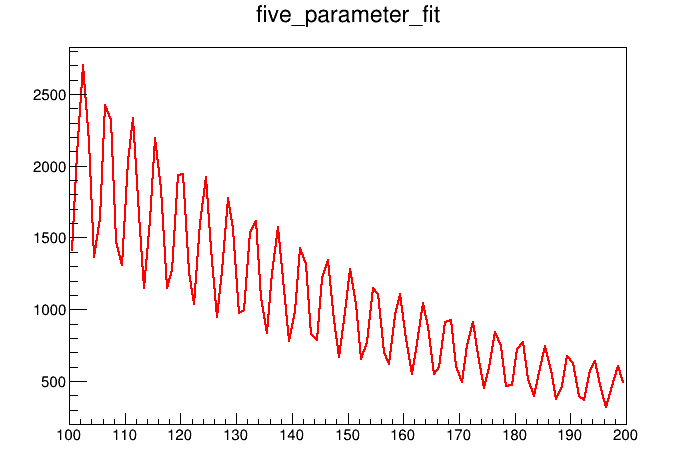

In [62]:
c = r.TCanvas()
fit.f.Draw()
c.Draw()

In [55]:
h = r.TH1D("h","h",1000,100,200)
for i in range(h.GetNbinsX()):
    h.SetBinContent(i, fit.f.Eval(h.GetBinCenter(i) + 1000))

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


 FCN=1.34881e-05 FROM MIGRAD    STATUS=FAILED        322 CALLS         323 TOTAL
                     EDM=2.71361e-05    STRATEGY= 1      ERR MATRIX APPROXIMATE
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a            1.79662e-03   2.18927e-02   2.06129e-06  -2.03968e-01
   2  a            6.45059e+01   3.61374e+02   3.19350e-02  -9.88084e-06
   3  a            3.28204e-01   3.08525e+00   1.50104e-03  -3.03479e-04
   4  a            8.79587e+02   2.46008e+05   2.80807e+00   2.47253e-08
   5  a            4.25147e-01   4.97051e+01   4.72253e-03  -2.32567e-05


Warning in <Fit>: Abnormal termination of minimization.


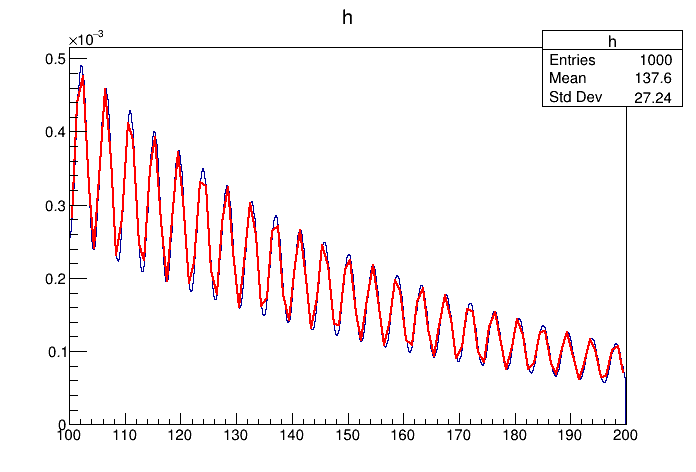

In [56]:
c = r.TCanvas()
h.Draw()
h.Fit(fit.name)
c.Draw()